In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from math import gamma
from scipy.stats import gamma as gamma_dense

from prml.utils.encoder import LabelToOnehot
from prml.utils.datasets import ClassificationDataGenerator2
from prml.mixture_models import KMeans

from prml.approximate_inference import (
    VariationalGauss1D,
    VariationalGaussianMixture,
    VariationalLogisticRegression
)

In [2]:
def gauss_distribution(x,mu,lamda):
    return (lamda/(2*np.pi))**0.5 * np.exp(-(x-mu)**2*lamda*0.5)

# Posterior distribution for 1D Gaussian 

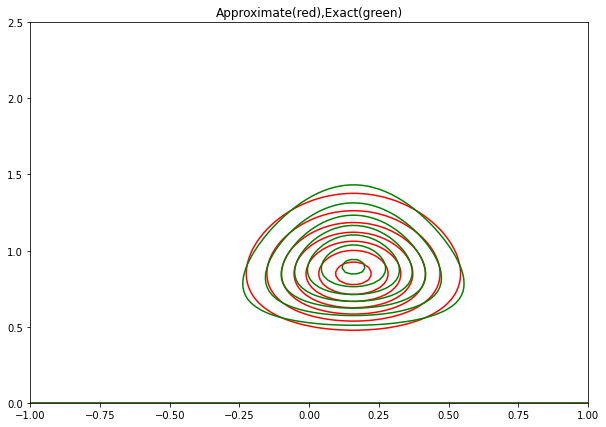

In [3]:
## parameter for prior distribution
a_0 = 0 
b_0 = 0 
mu_0 = 0 
lam_0 = 0 

## caluculate approximate posterior distribution
N = 30 
X_data = np.random.randn(N)
vgauss1d = VariationalGauss1D(max_iter=100,threshold=1e-7,a=a_0,b=b_0,mu=mu_0,lamda=lam_0)
vgauss1d.fit(X_data)


fig,ax = plt.subplots(1,1,figsize=(10,7))
x = np.linspace(-1,1,100)
y = np.linspace(0,2.5,100) 
X,Y = np.meshgrid(x,y)

## approximate solution
a = vgauss1d.a 
b = vgauss1d.b 
mu = vgauss1d.mu 
lam = vgauss1d.lamda 

prob = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        prob[i][j] = gamma_dense.pdf(Y[i][j],a=a,scale=1/b)*gauss_distribution(X[i][j],mu,lam)

ax.contour(X,Y,prob,colors=["red"])

## exact solution
a_N = a_0 + (N + 1)/2 
b_N = b_0 - (lam_0*mu_0 + N*X_data.mean())**2 / (2*(lam_0 + N)) + lam_0*mu_0**2/2 + np.sum(X_data**2)/2 
mu_N = (lam_0*mu_0 + N*X_data.mean()) / (lam_0 + N) 
lam_N = N + lam_0

prob = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        prob[i][j] = gamma_dense.pdf(Y[i][j],a=a_N,scale=1/b_N)*gauss_distribution(X[i][j],mu_N,lam_N*Y[i][j])

ax.contour(X,Y,prob,colors=["green"])
ax.set_title("Approximate(red),Exact(green)")
plt.show()

# Ancestral Sampling 

In [9]:
def gm_sampling(n=100,pi=None,mu=None,sigma=None):
    if pi is None:
        assert mu is None and sigma is None 
        pi = np.ones((3)) / 3 
        mu = np.array([
            np.array([1,1]),
            np.array([-1,-1]),
            np.array([1,-1])
        ])
        sigma = np.array([np.eye(2) for _ in range(3)])
    
    z = np.random.multinomial(1,pi,size=n) 
    X = np.zeros((n,mu.shape[1])) 
    N = np.sum(z,axis = 0)
    for k in range(pi.shape[0]):
        n_k = N[k]
        X[z[:,k] == 1,:] = np.random.multivariate_normal(mu[k],sigma[k],n_k)
    return X 

# Variational Gaussian Mixture 

We can get optimal number of components by Baysian method even if the number of data is small

K is reduced from 5 to 3


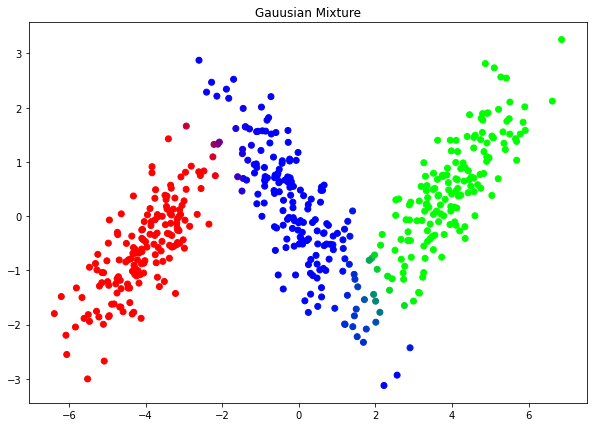

In [5]:
pi = np.array([1/3,1/3,1/3]) 
mu = np.array([
    [-4.0,-0.5],
    [0,0],
    [4.0,0.5]
])
sigma = np.array([
    [[1,0.8],[0.8,1]],
    [[1,-0.8],[-0.8,1]], 
    [[1,0.8],[0.8,1]]
])

X = gm_sampling(n = 500,pi=pi,mu=mu,sigma=sigma)

K_org = 5
km = KMeans(K = K_org) 
cluster,_ = km.fit(X)
l2o = LabelToOnehot()
init_responsibility = l2o.fit_transform(cluster) 

vgm = VariationalGaussianMixture(K = K_org,n_iter=200)
vgm.fit(X,initial_responsibility=init_responsibility,reduce_components=True,threshold=1e-2)
responsibility = vgm.r 

print(f"K is reduced from {K_org} to {vgm.K}")

fig,ax = plt.subplots(1,1,figsize=(10,7))
ax.scatter(X[:,0],X[:,1],c=responsibility)
ax.set_title("Gauusian Mixture")
plt.show()

## Predictive density

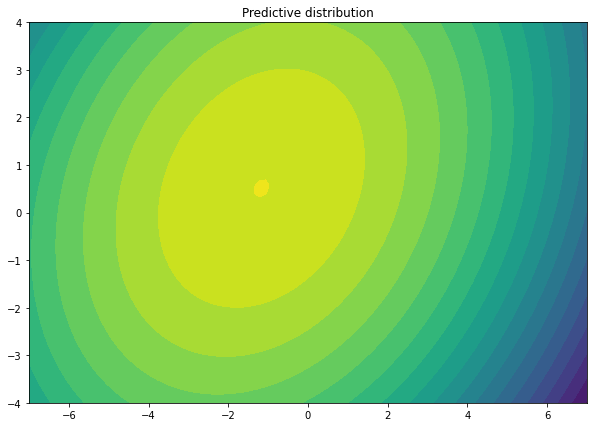

In [6]:
fig,ax = plt.subplots(1,1,figsize=(10,7))
x = np.linspace(-7,7,100)
y = np.linspace(-4,4,100) 
X,Y = np.meshgrid(x,y)

data = np.vstack((X.ravel(),Y.ravel())).T 
prob = vgm.prob_density(data)
prob = prob.reshape(100,100)

ax.contourf(X,Y,prob,levels=20)
ax.set_title("Predictive distribution")
plt.show()

# Variational Logistic Regression

In [10]:
# for decision boundry 
def g(x): 
    return x*x/2 - 1

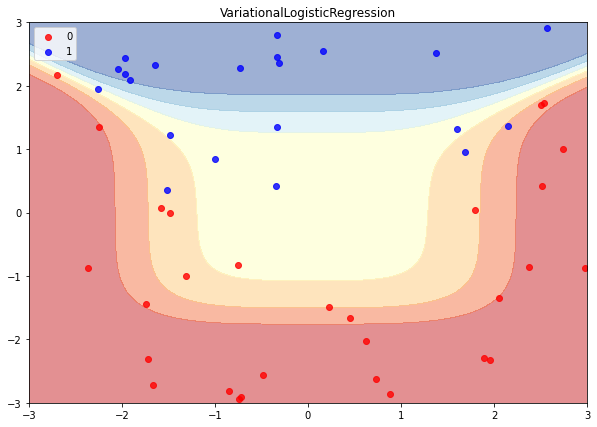

In [8]:
gen = ClassificationDataGenerator2(g) 
X_tr,y_tr = gen(encoding="label",x_lower=-3,x_upper=3,y_lower=-3,y_upper=3)  

vlr = VariationalLogisticRegression(basis_function="polynomial",deg=5) 
vlr.fit(X_tr,y_tr,optimize_param=True)

x = np.linspace(-4,4,100)
y = np.linspace(-4,4,100)
xs,ys = np.meshgrid(x,y)
probs = vlr.predict(np.array([xs.ravel(),ys.ravel()]).T,return_prob=True).ravel() 
probs = probs.reshape(xs.shape)

cmap = plt.get_cmap("RdYlBu")
figure,axes = plt.subplots(1,1,figsize=(10,7))
axes.contourf(xs,ys,probs,alpha=0.5,cmap = cmap)
axes.set_xlim(-3,3)
axes.set_ylim(-3,3)

axes.scatter(x = X_tr[y_tr == 0,0],
            y = X_tr[y_tr == 0,1],
            alpha = 0.8,
            c = "red",
            label = "0")
axes.scatter(x = X_tr[y_tr == 1,0],
            y = X_tr[y_tr == 1,1],
            alpha = 0.8,
            c = "blue",
            label = "1")

axes.set_title("VariationalLogisticRegression")
plt.legend()
plt.show()